In [2]:
#데이터 불러오기
import pyupbit
from pyupbit.quotation_api import get_tickers



ETH_price = pyupbit.get_current_price("KRW-ETH")


df_ETH = pyupbit.get_ohlcv("KRW-ETH","hour",1581, to = '20220501')
df_ETH = df_ETH.drop("value",axis=1)
print(df_ETH)



                          open       high        low      close         volume
2018-01-01 09:00:00  1028000.0  1076000.0  1011500.0  1057000.0   51315.571156
2018-01-02 09:00:00  1056500.0  1270500.0  1051000.0  1177000.0  158481.289301
2018-01-03 09:00:00  1177000.0  1324500.0  1157500.0  1295500.0   83430.944304
2018-01-04 09:00:00  1295500.0  1518000.0  1269000.0  1439500.0   97018.955981
2018-01-05 09:00:00  1439500.0  1645000.0  1406500.0  1554500.0  109665.854669
...                        ...        ...        ...        ...            ...
2022-04-26 09:00:00  3766000.0  3799000.0  3553000.0  3596000.0   39317.760548
2022-04-27 09:00:00  3597000.0  3702000.0  3580000.0  3677000.0   24282.807473
2022-04-28 09:00:00  3677000.0  3786000.0  3646000.0  3737000.0   26791.875509
2022-04-29 09:00:00  3737000.0  3753000.0  3603000.0  3628000.0   26801.567048
2022-04-30 09:00:00  3630000.0  3656000.0  3564000.0  3570000.0   17625.435214

[1581 rows x 5 columns]


In [3]:
#결측치 확인
df_ETH.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [4]:
#minmax 정규화
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
df_ETH = df_ETH.drop('volume',axis=1)
df_ETH = sc.fit_transform(df_ETH)

In [5]:
#훈련데이터, 시험데이터 나누기
import pandas as pd
df_ETH = pd.DataFrame(df_ETH)

df_train = df_ETH.iloc[:1200,:5].values
df_test = df_ETH.iloc[:381,:5].values

In [6]:
#학습에 사용할 수 있도록 input 데이터 조정하기
import numpy as np

x_train = []
y_train = []
y_train_stacked = []

for i in range(3,1199):
    x_train.append(df_train[i-3:i,:])
    y_train.append(df_train[i:i+1,3])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(1196,3,4))


x_test = []
y_test = []

for i in range(3,380):
    x_test.append(df_test[i-3:i,:])
    y_test.append(df_test[i:i+1,3])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test,(377,3,4))


In [7]:
y_train.shape

(1196, 1)

In [8]:
#LSTM 모델
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import RMSprop, Nadam, Adam

lstm_model = Sequential()

lstm_model.add(LSTM(units = 50,
                    return_sequences = True,
                    input_shape = (3,4),
                    activation = 'tanh'))

lstm_model.add(LSTM(units = 50,
                    activation = 'tanh'))

lstm_model.add(Dense(units = 1))

lstm_model.compile(optimizer = Nadam(lr=0.01),
                  loss = 'Huber')

lstm_model.fit(x_train,y_train, epochs = 100, batch_size = 32, verbose = 0)



C:\Users\USER\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [9]:
#예측값
lstm_prediction = lstm_model.predict(x_test)

lstm_prediction.shape

12/12 [==============================] - 1s 2ms/step


(377, 1)

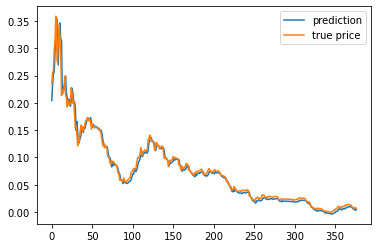

In [10]:
#예측값과 실제값 비교하기
import matplotlib.pyplot as plt

x1 = []
for i in range(377):
    x1.append(i)

    
x2 = []
for i in range(377):
    x2.append(i)  
        
    
plt.plot(x1,lstm_prediction,label = 'prediction')
plt.plot(x2, y_test,label = 'true price')
plt.legend()
plt.show()


In [21]:
# 정규화 복원하기
a = np.zeros((377,4))
b = a + lstm_prediction
lstm_prediction_orginal = sc.inverse_transform(b)

print(lstm_prediction_orginal)

[[1261782.16743693 1282379.22346458 1232594.73745748 1261782.16743693]
 [1425607.60945529 1448887.58662671 1392604.6479091  1425607.60945529]
 [1544723.64904433 1569954.35460836 1508946.44801766 1544723.64904433]
 ...
 [ 124702.28580269  126677.71860133  121997.70322978  124702.28580269]
 [ 112770.99857815  114551.03619047  110344.29838099  112770.99857815]
 [ 121061.69005074  122977.50188209  118441.89777561  121061.69005074]]


In [ ]:
사용한 하이퍼 파라미터
1. 정규화 : minmax
2. time series : 3 (몇개의 series로 예측할 건지)
3. period : 1(몇개의 series를 예측할 건지)
4. 학습데이터/시험데이터 : 1200/381
5. lstm : 코드참조
6. optimizer : Nadam
7. loss : Huber
8. 학습률 : 0.01
9. 에폭 : 100
10. 배치사이즈 : 32

보완점
1. 정규화 하고 복원하기
2. 배치 정규화
3. 하이퍼 파라미터 조정
4. LSTM층 다양하게 만들기
5. early stop
6. dropout
7. 그래프 이쁘게 손보기



